# PHYSBO の基本

## はじめに


本チュートリアルでは例として、Cuの安定した界面構造の探索問題を扱います。 目的関数の評価にあたる構造緩和計算には、実際には1回あたり数時間といったオーダーの時間を要しますが、本チュートリアルでは既に評価済みの値を使用します。問題設定については、以下の文献を参照してください。

- S. Kiyohara, H. Oda, K. Tsuda and T. Mizoguchi, “Acceleration of stable interface structure searching using a kriging approach”, Jpn. J. Appl. Phys. 55, 045502 (2016).

---

それではサンプルデータを用いて、各手順を実際に行ってみましょう。

はじめに、PHYSBOをインポートします。

In [1]:
import physbo

## 探索候補データの準備

まず、以下を実行してサンプルデータをダウンロードしてください。

In [2]:
import os
import urllib2
import ssl
import numpy as np

ssl._create_default_https_context = ssl._create_unverified_context

def download():
    if not os.path.exists('data/s5-210.csv'):

        if not os.path.exists('data'):
            os.mkdir('data')
            
        print('Downloading...')
        response = urllib2.urlopen("http://www.tsudalab.org/files/s5-210.csv")
        with open('data/s5-210.csv', 'wb') as out_file:
            out_file.write(response.read())
        response.close()
        print('Done')
        
def load_data():
    download()
    A =  np.asarray(np.loadtxt('data/s5-210.csv',skiprows=1, usecols=(3,4,5,6), delimiter=',') )
    X = A[:,0:3]
    t  = -A[:,3]
    return X, t

In [3]:
X, t = load_data()

以下、N: 探索候補の数  , d: 入力パラメータの次元数  とします。

X は N x d 次元の行列で、各行は探索候補である各パラメータセット (d 次元のベクトル) を表します。  
t は N 次元のベクトルで、各探索候補の負のエネルギー(最適化したい目的関数の値) と対応します。  

**PHYSBO では最適化の方向は「最大化」だと仮定します。**  

元々の問題設定は「エネルギー最小化」ですが、PHYSBOで最適化を行うにあたって、目的関数値にマイナスを掛けて「負のエネルギーの最大化」問題として扱っています。

t は実際には不明ですが、ここでは既に取得された値を利用します。  

In [4]:
X

array([[0. , 1. , 0. ],
       [0. , 1. , 0.1],
       [0. , 1. , 0.2],
       ...,
       [8. , 1.5, 3.4],
       [8. , 1.5, 3.5],
       [8. , 1.5, 3.6]])

In [5]:
t

array([-1.01301176, -1.01487066, -1.02044168, ..., -1.11680203,
       -2.48876352, -2.4971452 ])

探索パラメータのスケールを合わせるため、X の各列についてそれぞれ、平均が0, 分散が 1 となるよう標準化します。

In [6]:
X = physbo.misc.centering( X )

In [7]:
X

array([[-1.71079785, -1.46385011, -1.68585446],
       [-1.71079785, -1.46385011, -1.59219588],
       [-1.71079785, -1.46385011, -1.4985373 ],
       ...,
       [ 1.71079785,  1.46385011,  1.4985373 ],
       [ 1.71079785,  1.46385011,  1.59219588],
       [ 1.71079785,  1.46385011,  1.68585446]])

## simulator の定義

PHYSBO に与える simulator クラスを定義します。  
`__call__` メソッドの返り値が、action を与えたときの目的関数値となります。  
action は探索候補の ID (0, 1, ..., N-1) を表します。

本チュートリアルでは、action が与えられたときに、既に計算された t の値をそのまま返すだけの simulator を定義しています。  
他の問題に適用する際は、simulator クラスをカスタマイズしてください。

In [8]:
class simulator:
    def __init__( self ):
        _, self.t = load_data()
    
    def __call__( self, action ):
        return self.t[action]

## 最適化の実行

### policy のセット

まず、最適化の policy をセットします。  

`test_X` に探索候補の行列 (numpy.array) を指定します。

In [9]:
# policy のセット 
policy = physbo.search.discrete.policy(test_X=X)

# シード値のセット 
policy.set_seed(0)

policy をセットした段階では、まだ最適化は行われません。
policy に対して以下のメソッドを実行することで、最適化を行います。

- `random_search`  
- `bayes_search`

これらのメソッドに先ほど定義した simulator と探索ステップ数を指定すると、探索ステップ数だけ以下のループが回ります。

1. パラメータ候補の中から次に実行するパラメータを選択
2. 選択されたパラメータで simulator を実行

1で返されるパラメータはデフォルトでは1つですが、1ステップで複数のパラメータを返すことも可能です。
詳しくは「複数候補を一度に探索する」の項目を参照してください。  

また、上記のループを PHYSBO の中で回すのではなく、1 と 2 を別個に外部から制御することも可能です。つまり、PHYSBO から次に実行するパラメータを推薦してもらい、それをPHYSBOの外部で何らかの形で評価し、評価値をPHYSBOに登録する、という手順が可能です。  
詳しくは「インタラクティブに実行する」の項目を参照してください。

### ランダムサーチ

まず初めに、ランダムサーチを行ってみましょう。

ベイズ最適化の実行には、目的関数値が1つ以上求まっている必要があるため、まずランダムサーチを実行します。   

**引数**  

- `max_num_probes`: 探索ステップ数  
- `simulator`: 目的関数のシミュレータ (simulator クラスのオブジェクト) 

In [ ]:
res = policy.random_search(max_num_probes=20, simulator=simulator())

実行すると、各ステップの目的関数値とその action ID、現在までのベスト値とその action ID が以下のように出力されます。

```
0020-th step: f(x) = -1.048733 (action=1022)
   current best f(x) = -0.963795 (best action=5734) 
```


### ベイズ最適化

続いて、ベイズ最適化を以下のように実行します。

**引数**  

- `max_num_probes`: 探索数  
- `simulator`: 目的関数のシミュレータ (simulator クラスのオブジェクト)  
- `score`: 獲得関数(acquisition function) のタイプ。以下のいずれかを指定します。
    - TS (Thompson Sampling)  
    - EI (Expected Improvement)  
    - PI (Probability of Improvement)  
- `interval`:  
指定したインターバルごとに、ハイパーパラメータを学習します。  
負の値を指定すると、ハイパーパラメータの学習は行われません。  
0 を指定すると、ハイパーパラメータの学習は最初のステップでのみ行われます。  
- `num_rand_basis`: 基底関数の数。0を指定すると、通常のガウス過程が使用されます。  

In [ ]:
res = policy.bayes_search(max_num_probes=80, simulator=simulator(), score='TS', 
                                                  interval=20, num_rand_basis=5000)

## 結果の確認

探索結果 res は history クラスのオブジェクト (`physbo.search.discrete.results.history`) として返されます。  
以下より探索結果を参照します。

- `res.fx` : simulator (目的関数) の評価値の履歴。
- `res.chosed_actions`: simulator を評価したときの action ID の履歴。  
- `fbest, best_action= res.export_all_sequence_best_fx()`: simulator を評価した全タイミングにおけるベスト値とその action ID の履歴。
- `res.total_num_search`: simulator のトータル評価数。

各ステップでの目的関数値と、ベスト値の推移をプロットしてみましょう。  
`res.fx`, `best_fx` はそれぞれ `res.total_num_search` までの範囲を指定します。

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

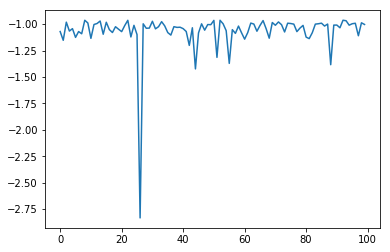

In [13]:
plt.plot(res.fx[0:res.total_num_search])

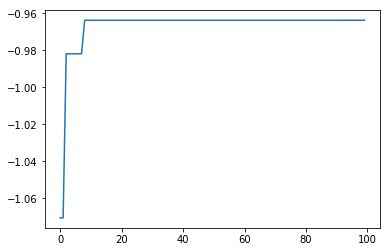

In [14]:
best_fx, best_action = res.export_all_sequence_best_fx()
plt.plot(best_fx)

## 結果のシリアライズ

探索結果は `save` メソッドにより外部ファイルに保存できます。

In [15]:
res.save('test.npz')

In [16]:
del res

保存した結果ファイルは以下のようにロードします。

In [17]:
res = physbo.search.discrete.results.history()
res.load('test.npz')